In [124]:
import torch
import torch.functional as F
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
class BSpline(torch.nn.Module):
    def __init__(self, num_knots=10, degree=3):
        """Initialize a B-Spline

        Args:
            num_knots (int, optional): number of knots in B-spline. Defaults to 10.
            degree (int, optional): degree of polynomials. Defaults to 3.
        """
        super(BSpline, self).__init__()
        # should the knots be learnable?
        self.num_knots = num_knots

        self.degree = degree

        # initialize knots 
        self.knots = torch.cat([torch.zeros(3), torch.linspace(0, 1, num_knots - 6), torch.ones(3)])
        # put knots on the endpoints so they don't always evaluate to 0

        # learnable coefficients for each basis function
        num_coeficents = num_knots - 1 - degree
        self.coefficients = torch.nn.Parameter(torch.randn(num_coeficents))

    def basis_function(self, i, k, x):
        """Recursively perform linear interpolation to compute the B-spline basis function

        Args:
            i (int): index of the knot
            k (int): degree of the polynomial
            x (torch.Tensor): input value

        Returns:
            torch.Tensor: value of the basis function at x
        """
        if k == 0:
            # at base case, return 1 if x is in the interval [knots[i], knots[i + 1]) and 0 otherwise
            return ((x >= self.knots[i]) & (x < self.knots[i + 1])).float()
        else:
            # don't divide by zero...
            denominator_1 = self.knots[i + k] - self.knots[i]
            denominator_2 = self.knots[i + k + 1] - self.knots[i + 1]

            term_1 = 0 if denominator_1 == 0 else ((x - self.knots[i]) / denominator_1) * self.basis_function(i, k - 1, x)

            term_2 = 0 if denominator_2 == 0 else ((self.knots[i + k + 1] - x) / denominator_2) * self.basis_function(i + 1, k - 1, x)
            return term_1 + term_2

    def forward(self, x):
        """Forward pass of the B-spline"""
        n = len(self.coefficients)
        result = torch.zeros_like(x, dtype=torch.float32)
        for i in range(n):
            result += self.coefficients[i] * self.basis_function(i, self.degree, x)

        return result


degree = number of knots - number of control points (coefficients) - 1
number of coefficients = number of knots - degree - 1

In [126]:
# toy dataset
x = torch.linspace(0, 1, 1000)
y = torch.sin(x*5)

In [127]:
spline = BSpline(num_knots=10, degree=3)

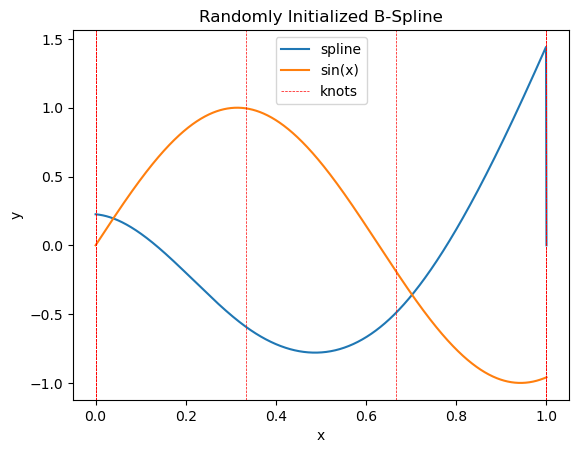

In [128]:
# plot the randomly initialized spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Randomly Initialized B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

In [129]:
# fit spline to data
num_itrs = 1_000
lr = 0.01
optimizer = torch.optim.Adam(spline.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    spline_out = spline(x)
    loss = torch.nn.functional.mse_loss(spline_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 1.5028767585754395
iteration 50, loss: 0.7901248931884766
iteration 100, loss: 0.3922993242740631
iteration 150, loss: 0.1899956613779068
iteration 200, loss: 0.092592254281044
iteration 250, loss: 0.047678638249635696
iteration 300, loss: 0.027412744238972664
iteration 350, loss: 0.018124239519238472
iteration 400, loss: 0.013575662858784199
iteration 450, loss: 0.011044907383620739
iteration 500, loss: 0.00937828328460455
iteration 550, loss: 0.008104508742690086
iteration 600, loss: 0.007040186785161495
iteration 650, loss: 0.006116555072367191
iteration 700, loss: 0.005306826904416084
iteration 750, loss: 0.004598104394972324
iteration 800, loss: 0.003981552552431822
iteration 850, loss: 0.0034493478015065193
iteration 900, loss: 0.0029938495717942715
iteration 950, loss: 0.002607481088489294


Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of B-Spline Over 1000 Training Iterations')

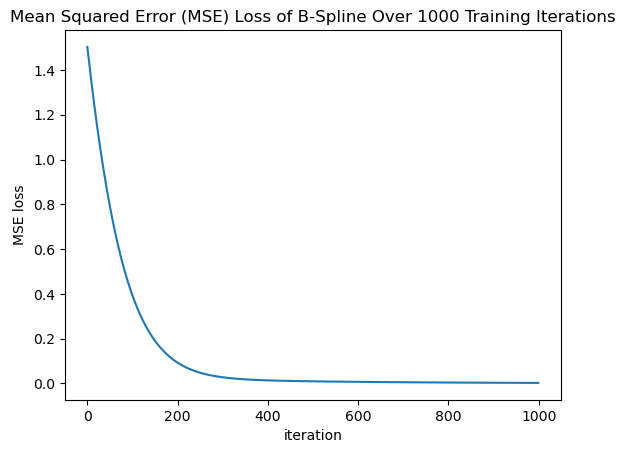

In [130]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of B-Spline Over {num_itrs} Training Iterations')

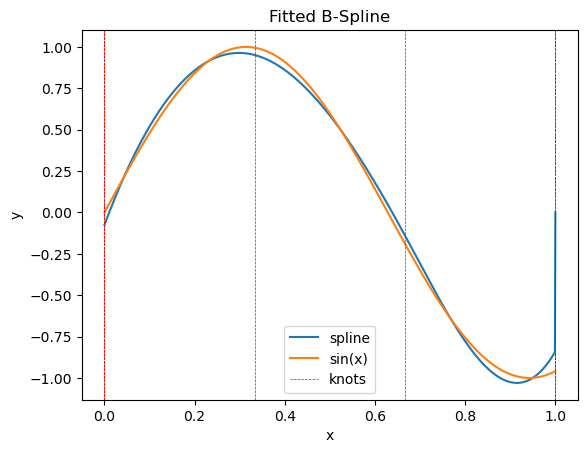

In [131]:
# plot the fitted spline
spline_out = spline(x).detach()

plt.plot(x, spline_out)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted B-Spline")

# insert verticle lines at the knots
for knot in spline.knots:
    plt.axvline(knot, color='r', linestyle='--', linewidth=0.5)

plt.legend(["spline", "sin(x)", 'knots'])

# GAM on Toy Dataset

In [132]:
# make toy dataset. in theory this could be modeled with a 1-layer KAN or a GAM with splines
num_samples = 100

transformations = [torch.sin, torch.log, lambda x: x**2]

num_features = len(transformations)

X = torch.rand(num_samples, num_features)

bias = torch.normal(mean=0, std=0.1, size=(1,))

# apply transformations to each feature and sum to get y
y = torch.sum(torch.stack([t(5 * X[:, i]) for i, t in enumerate(transformations)], dim=1), dim=1) + bias

# make sure no nan values
assert not torch.isnan(y).any()

X.shape, y.shape

(torch.Size([100, 3]), torch.Size([100]))

In [133]:
class GAM(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3):
        """Initialize a Generalized Additive Model (GAM) with B-splines

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 15.
            degree (int, optional): degree of the polynomial. Defaults to 3.
        """
        super(GAM, self).__init__()
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.bias = torch.nn.Parameter(torch.randn(1))

        # a little hacky; just so B-spline parameters are recognized by pytorch and learned
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

    def forward(self, X):
        """Forward pass of the GAM"""
        return torch.sum(torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1), dim=1) + self.bias

In [134]:
gam = GAM(num_features=num_features)

In [135]:
# fit GAM to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(gam.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    gam_out = gam(X)
    loss = torch.nn.functional.mse_loss(gam_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 152.4097900390625
iteration 50, loss: 117.89201354980469
iteration 100, loss: 92.53113555908203
iteration 150, loss: 73.92164611816406
iteration 200, loss: 60.27181625366211
iteration 250, loss: 50.22624206542969
iteration 300, loss: 42.68338394165039
iteration 350, loss: 36.826637268066406
iteration 400, loss: 32.10832595825195
iteration 450, loss: 28.184720993041992
iteration 500, loss: 24.84429931640625
iteration 550, loss: 21.954370498657227
iteration 600, loss: 19.427867889404297
iteration 650, loss: 17.204296112060547
iteration 700, loss: 15.239069938659668
iteration 750, loss: 13.497566223144531
iteration 800, loss: 11.951766014099121
iteration 850, loss: 10.578300476074219
iteration 900, loss: 9.357287406921387
iteration 950, loss: 8.271550178527832
iteration 1000, loss: 7.30612850189209
iteration 1050, loss: 6.447885513305664
iteration 1100, loss: 5.685230731964111
iteration 1150, loss: 5.0079026222229
iteration 1200, loss: 4.406755447387695
iteration 1250, 

Text(0.5, 1.0, 'Mean Squared Error (MSE) Loss of GAM Over 5000 Training Iterations')

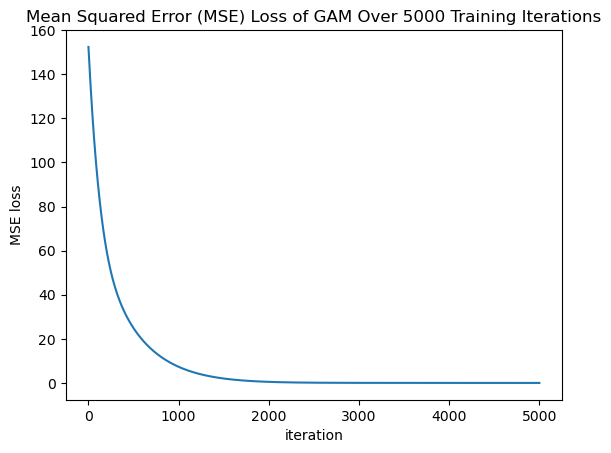

In [136]:
# plot losses
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('MSE loss')
plt.title(f'Mean Squared Error (MSE) Loss of GAM Over {num_itrs} Training Iterations')

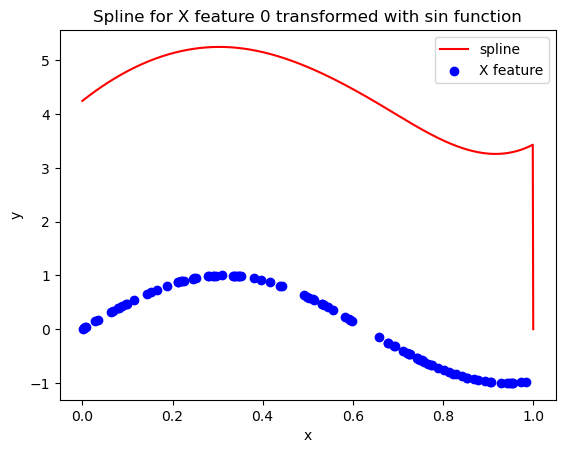

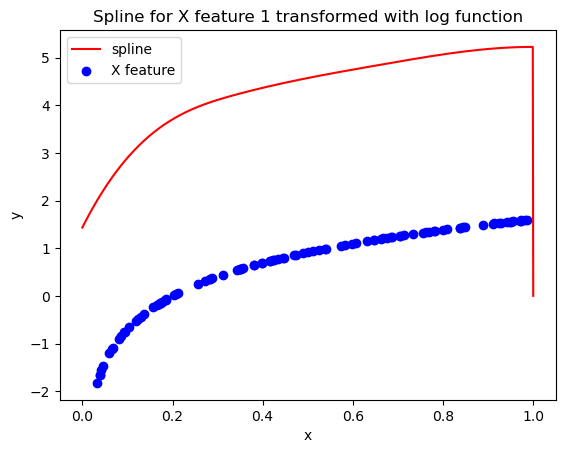

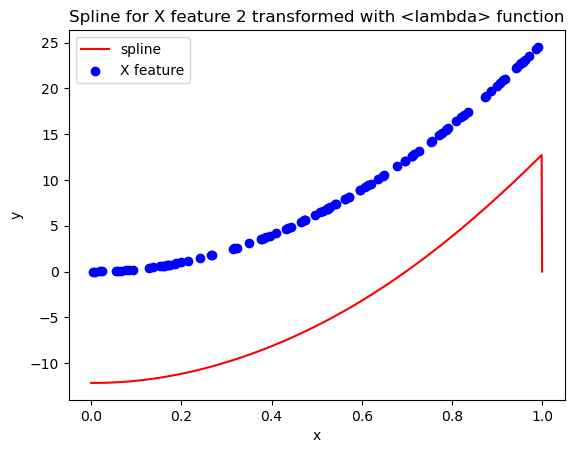

In [137]:
# plot splines

dummy_x = torch.linspace(0, 1, 1000)

for i, (spline, transformation) in enumerate(zip(gam.splines, transformations)):
    plt.plot(dummy_x, spline(dummy_x).detach(), c='r')
    
    x = X[:, i]
    plt.scatter(x, transformation(5 * x), c='b')
    plt.legend(["spline", "X feature"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Spline for X feature {i} transformed with {transformation.__name__} function")

    plt.show()

# One Layer KAN

It seems like the only difference between a one-layer KAN and a B-spline based GAM is how the activations are implemented.

In a GAM each function of the features in just a B-spline which is evaluated, summed, and added to a bias term to get a final output

In a one-layer KAN, instead of simply a b-spline, we have:

$$
\phi(x) = w_b \cdot b(x) + w_s \cdot \text{spline}(x)
$$

for each feature.

Where b(x) is a basis function. In the paper, they just use a SiLU activation function for it and claim the reasoning for using it is the same as the reasoning for residual blocks; helps to reduce loss of input signal

Finally, wb and ws are learnable parameters that control the relative importance of each function and its associated feature. The authors explain that these two parameters are technically reduntant since they can be 'absorbed' into the spline and the basis but are nonetheless included to control the magnitude of the activation function. 



In [138]:
class OneLayerKAN(torch.nn.Module):
    def __init__(self, num_features, num_knots=10, degree=3, basis_function='silu'):
        """Initialize a one-layer Kolmogorov-Arnold Network (KAN)

        Args:
            num_features (int): number of features in the input
            num_knots (int, optional): number of knots in each B-spline. Defaults to 10.
            degree (int, optional): degree of the B-spline polynomials. Defaults to 3.
            basis_function (str, optional): basis function for each activation function. Defaults to 'silu'.
        """
        super(OneLayerKAN, self).__init__()
        # not bothering to initialize the way they do it in the paper
        self.splines = [BSpline(num_knots=num_knots, degree=degree) for i in range(num_features)]

        self.basis_function = getattr(torch.nn.functional, basis_function)
        
        self.parameters = nn.ParameterList([spline.coefficients for spline in self.splines])

        self.basis_coefficients = torch.nn.Parameter(torch.randn(num_features))
        self.spline_coefficients = torch.nn.Parameter(torch.randn(num_features))

    def forward(self, X):
        """Forward pass of the one-layer KAN"""
        # ϕ(x) = wb * b(x) + ws * spline(x)
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output @ self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output @ self.basis_coefficients
        
        # ϕ(x) = wb * b(x) + ws * spline(x)
        return basis_output_weighted + spline_output_weighted
    
    def get_activations(self, X):
        """
        Get the raw activations of the KAN without the final sum
        Useful for interpretability...
        """
        # obtain raw activations (basis + spline outputs) without final sum
        spline_output = torch.stack([spline(X[:, i]) for i, spline in enumerate(self.splines)], dim=1)
        spline_output_weighted = spline_output * self.spline_coefficients

        basis_output = self.basis_function(X)
        basis_output_weighted = basis_output * self.basis_coefficients
        
        return basis_output_weighted + spline_output_weighted    

In [139]:
kan = OneLayerKAN(num_features=num_features)

In [140]:
# fit KAN to data
num_itrs = 5_000
lr = 0.01
optimizer = torch.optim.Adam(kan.parameters(), lr=lr)

losses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()
    kan_out = kan(X)
    loss = torch.nn.functional.mse_loss(kan_out, y)
    loss.backward()
    optimizer.step()

    losses[i] = loss.detach()

    if i % 50 == 0:
        print(f'iteration {i}, loss: {loss.item()}')

iteration 0, loss: 103.0597152709961
iteration 50, loss: 61.347782135009766
iteration 100, loss: 34.330894470214844
iteration 150, loss: 20.94295883178711
iteration 200, loss: 12.587246894836426
iteration 250, loss: 7.118266582489014
iteration 300, loss: 3.764666795730591
iteration 350, loss: 1.9267278909683228
iteration 400, loss: 1.0108071565628052
iteration 450, loss: 0.5672081112861633
iteration 500, loss: 0.34135153889656067
iteration 550, loss: 0.21644726395606995
iteration 600, loss: 0.14265331625938416
iteration 650, loss: 0.09715908020734787
iteration 700, loss: 0.06824354082345963
iteration 750, loss: 0.04939110204577446
iteration 800, loss: 0.03680865839123726
iteration 850, loss: 0.02821188047528267
iteration 900, loss: 0.022187387570738792
iteration 950, loss: 0.017845410853624344
iteration 1000, loss: 0.014620989561080933
iteration 1050, loss: 0.012154369615018368
iteration 1100, loss: 0.010215571150183678
iteration 1150, loss: 0.008656305260956287
iteration 1200, loss: 0

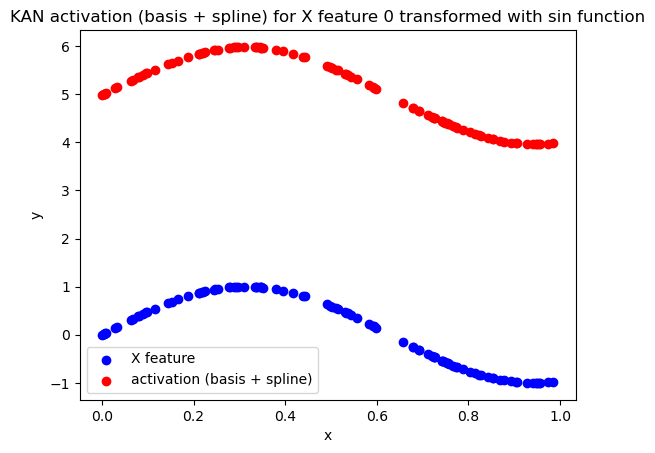

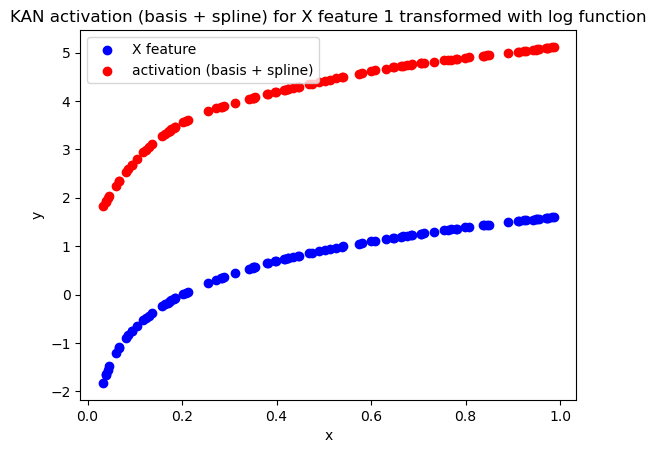

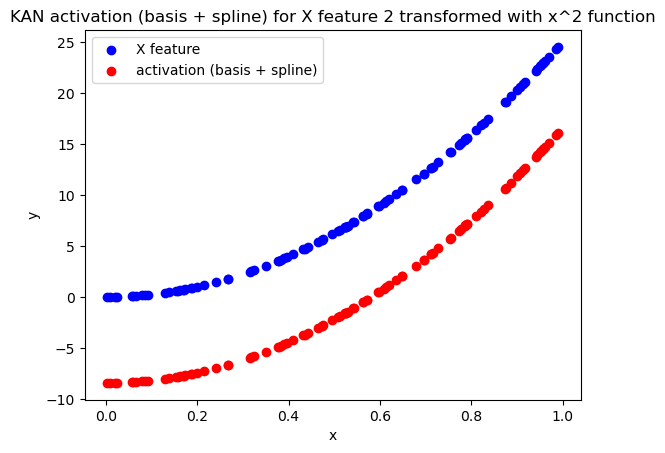

In [142]:
# plot kan activations
activations = kan.get_activations(X).detach().numpy()

transformation_names = ['sin', 'log', 'x^2']

for i, (feature_activation, transformation) in enumerate(zip(activations.T, transformations)):
    plt.scatter(X[:, i], transformation(5 * X[:, i]), c='b')
    plt.scatter(X[:, i], feature_activation, c='r')
    plt.legend(["X feature", "activation (basis + spline)"])

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"KAN activation (basis + spline) for X feature {i} transformed with {transformation_names[i]} function")

    plt.show()
